In [1]:
import random
import math
import copy
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
import matplotlib.colors as C
import matplotlib.patches as PA

# TOY POMDP problem

|S| = 3

|A| = 2

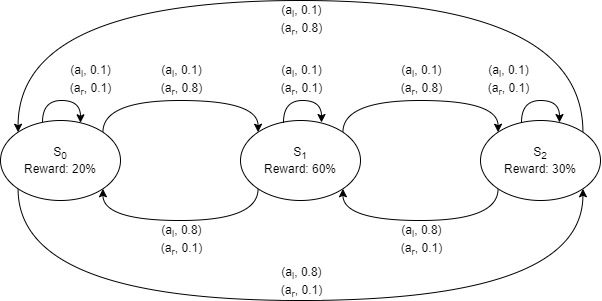

## Useful fncts

In [2]:
def plotSimplex(points, fig=None, 
                vertexlabels=['s_0','s_1','s_2'],
                **kwargs):
    """
    Plot Nx3 points array on the 3-simplex 
    (with optionally labeled vertices) 
    
    kwargs will be passed along directly to matplotlib.pyplot.scatter    
    Returns Figure, caller must .show()
    """
    if(fig == None):        
        fig = plt.figure()
    # Draw the triangle
    l1 = L.Line2D([0, 0.5, 1.0, 0], # xcoords
                  [0, np.sqrt(3) / 2, 0, 0], # ycoords
                  color='k')
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(MT.NullLocator())
    fig.gca().yaxis.set_major_locator(MT.NullLocator())
    # Draw vertex labels
    fig.gca().text(-0.05, -0.05, vertexlabels[0])
    fig.gca().text(1.05, -0.05, vertexlabels[1])
    fig.gca().text(0.5, np.sqrt(3) / 2 + 0.05, vertexlabels[2])
    # Project and draw the actual points
    projected = projectSimplex(points)
    plt.scatter(projected[:,0], projected[:,1], **kwargs)              
    # Leave some buffer around the triangle for vertex labels
    fig.gca().set_xlim(-0.2, 1.2)
    fig.gca().set_ylim(-0.2, 1.2)

    return fig    

def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    tripts = np.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * np.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / np.sqrt(3)) * p1 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p1 * np.sin(np.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / np.sqrt(3)) * p2 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p2 * np.sin(np.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / np.sqrt(3) * p3)
      
        tripts[idx,:] = (x,y)

    return tripts

def display_belief_set(belief_set):
    fig = plt.figure(figsize=(15,15))

    cmap = CM.get_cmap('Blues')
    norm = C.Normalize(vmin=0, vmax=len(belief_set))
    c = range(len(belief_set))
    # Do scatter plot
    fig = plotSimplex(np.array(belief_set), fig=fig, s=20, c=c,                      
                      cmap=cmap, norm=norm)

    plt.show()

In [3]:
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

## Problem setup

Clumsy robot

In [4]:
LEFT = -1
RIGHT = 1
ACTIONS = [LEFT, RIGHT]
ACTION_INDEX = {a:a_i for a_i, a in enumerate(ACTIONS)}
ACTION_COUNT = len(ACTIONS)

STATES = [0,1,2]
STATE_COUNT = len(STATES)

In [5]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup tanle to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, len(ACTIONS), STATE_COUNT))
for s in STATES:
    for a_i, a in enumerate(ACTIONS):
        for s_p in STATES:
            transition_table[s,a_i,s_p] = transition_function(s,a,s_p)

# Randomized transition
def transition(s,a):
    a_i = ACTION_INDEX[a]
    s_p_probs = [transition_table[s, a_i, s_p] for s_p in STATES]
    return np.argmax(np.random.multinomial(n=1, pvals=s_p_probs))

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.1, 0.1, 0.8],
       [0.8, 0.1, 0.1],
       [0.1, 0.8, 0.1]])

In [6]:
OBS_RND = 0.7 # 70% of observation success
def observation_function(a, s_p, o):
    return OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)

observation_table = np.zeros((len(ACTIONS), STATE_COUNT, STATE_COUNT))
for a_i, a in enumerate(ACTIONS):
    for s_p in STATES:
        for o in STATES:
            observation_table[a_i, s_p, o] = observation_function(a, s_p, o)

# Random observation 
def observe(s):
    return s if random.random() < OBS_RND else random.choice(list(set(STATES) - set([s])))
            
observation_table[0,:,:]

array([[0.7 , 0.15, 0.15],
       [0.15, 0.7 , 0.15],
       [0.15, 0.15, 0.7 ]])

In [7]:
REWARD_PROBS = [0.2, 0.6, 0.3]
def reward(s):
    return 1 if random.random() < REWARD_PROBS[s] else 0

def reward_function(s, a):
    tot = 0.0
    for s_p in STATES:
        a_i = ACTION_INDEX[a]
        tot += (REWARD_PROBS[s_p] * transition_table[s,a_i,s_p])
    return tot

def immediate_rewards(a):
    return [reward_function(s,a) for s in STATES]

reward_table = np.zeros((STATE_COUNT, len(ACTIONS)))
for s in STATES:
    for a_i,a in enumerate(ACTIONS):
        reward_table[s,a_i] = reward_function(s,a)
        
reward_table

array([[0.32, 0.53],
       [0.25, 0.32],
       [0.53, 0.25]])

In [8]:
for a in ACTIONS:
    for s in STATES:
        print(f'R({s}, {"LEFT" if a == LEFT else "RIGHT"}) = {reward_function(s,a)}')

R(0, LEFT) = 0.32
R(1, LEFT) = 0.25
R(2, LEFT) = 0.53
R(0, RIGHT) = 0.53
R(1, RIGHT) = 0.32
R(2, RIGHT) = 0.25


In [9]:
def rand_state_from_belief(b):
    return np.argmax(np.random.multinomial(n=1, pvals=b))

# TEST
tots = {0:0, 1:0, 2:0}
n = 10000
distrib = [0.1, 0.2, 0.7]
for sample in range(n):
    s = rand_state_from_belief(distrib)
    tots[s] += 1

for key, val in tots.items():
    print(f'{key}: {val/n} (exp {distrib[key]})')

0: 0.0986 (exp 0.1)
1: 0.199 (exp 0.2)
2: 0.7024 (exp 0.7)


## PBVI: Point Based Value Iteration

### Initial Parameters

In [10]:
gamma_0 = np.array([immediate_rewards(a) for a in ACTIONS])
gamma_0

array([[0.32, 0.25, 0.53],
       [0.53, 0.32, 0.25]])

In [11]:
b_0 = np.array([1/STATE_COUNT for _ in STATES])
b_0

array([0.33333333, 0.33333333, 0.33333333])

### Belief update

In [12]:
def belief_update(b_prev, a, o):
    b_new = np.zeros((STATE_COUNT))
    a_i = ACTION_INDEX[a]
    
    for s_p in STATES:
        b_new[s_p] = observation_table[a_i, s_p, o] * sum([(transition_table[s, a_i, s_p] * b_prev[s]) for s in STATES])

    # Formal definition of the normailizer as in papers
    # normalizer = 0
    # for s in STATES:
    #     normalizer += b_prev[s] * sum([(transition_function(s, a, o) * observation_function(a, s_p, o)) for s_p in STATES])
    
    normalizer = sum(b_new)
    
    for s in STATES:
        b_new[s] /= normalizer
    
    return b_new

In [13]:
# Test
belief_update(b_0, LEFT, 1)

array([0.15, 0.7 , 0.15])

### Backup step

In [14]:
def backup(belief_set, alpha_set, discount_factor=0.9):
    # Step 1
    gamma_a_o_t = {}
    for a in ACTIONS:
        for o in STATES:
            alpa_a_o_set = []
            
            for alpha_i in alpha_set:
                alpa_a_o_vect = []
                
                for s in STATES:
                    products = [(transition_table[s,a,s_p] * observation_table[a, s_p, o] * alpha_i[s_p]) for s_p in STATES]
                    alpa_a_o_vect.append(discount_factor * sum(products))
                    
                alpa_a_o_set.append(alpa_a_o_vect)
                
            if a not in gamma_a_o_t:
                gamma_a_o_t[a] = {o: alpa_a_o_set}
            else:
                gamma_a_o_t[a][o] = alpa_a_o_set

    # Step 2
    alpha_set_t = []
    alpha_actions = []
    
    for b in belief_set:
        
        best_alpha = None
        best_action = None
        best_alpha_val = -math.inf
        
        for a_i, a in enumerate(ACTIONS):
            
            obs_alpha_sum = np.zeros(STATE_COUNT)
            
            for o in STATES:
                
                # Argmax of alphas
                best_alpha_o = None
                best_alpha_o_val = -math.inf
                
                for alpha_o in gamma_a_o_t[a][o]:
                    val = np.dot(alpha_o, b)
                    if val > best_alpha_o_val:
                        best_alpha_o_val = val
                        best_alpha_o = alpha_o
                        
                # Sum of the alpha_obs vectors
                obs_alpha_sum += best_alpha_o
                    
            alpha_a_vect = reward_table[:,a_i] + obs_alpha_sum

            # Step 3
            val = np.dot(alpha_a_vect, b)
            if val > best_alpha_val:
                best_alpha_val = val
                best_alpha = alpha_a_vect
                best_action = a

        # Pruning step computationally expensive and saves very few vectors
        dominated = False
        # for other_vect in alpha_set_t:
        #     if all(np.array(best_alpha) < np.array(other_vect)):
        #         print(f'dominated by {other_vect}')
        #         dominated = True
        #     if all(np.array(best_alpha) > np.array(other_vect)):
        #         print(f'removing: {other_vect}')
        #         alpha_set_t.remove(other_vect)
        
        if not arreq_in_list(best_alpha, alpha_set_t) and not dominated:
            alpha_set_t.append(best_alpha)
            alpha_actions.append(best_action)
        else:
            # print('prune')
            pass
            
    return (alpha_set_t, alpha_actions)

In [15]:
# Test Backup funtion

belief_set = [b_0]
alpha_set = gamma_0

backup(belief_set, alpha_set)

([array([0.627845, 0.64384 , 0.956915])], [-1])

In [16]:
# Test Backup funtion

belief_set = [b_0]
alpha_set = gamma_0

alpha_set_new, alpha_actions = backup(belief_set, alpha_set)
for i, alpha in enumerate(alpha_set_new):
    print(f'Alpha vector with best action "{alpha_actions[i]}": {alpha}')

Alpha vector with best action "-1": [0.627845 0.64384  0.956915]


### Expand functions

#### Random Action

In [17]:
# Random action
def expand_ssra(belief_set, alpha_set, alpha_actions):
    belief_set_new = copy.deepcopy(belief_set)
    
    for b in belief_set:
        s = rand_state_from_belief(b)
        a = random.choice(ACTIONS)
        s_p = transition(s, a)
        o = observe(s_p)
        b_new = belief_update(b, a, o)
        
        belief_set_new.append(b_new)
        
    return belief_set_new

In [18]:
expand_ssra(belief_set, alpha_set_new, None)

[array([0.33333333, 0.33333333, 0.33333333]), array([0.15, 0.7 , 0.15])]

#### Greedy action

In [19]:
# Greedy action
def expand_ssga(belief_set, alpha_set, alpha_actions, eps=0.1):
    belief_set_new = copy.deepcopy(belief_set)
    
    for b in belief_set:
        s = rand_state_from_belief(b)
        
        if random.random() < eps:
            a = random.choice(ACTIONS)
        else:
            best_alpha_index = np.argmax(np.dot(alpha, b) for alpha in alpha_set)
            a = alpha_actions[best_alpha_index]
        
        s_p = transition(s, a)
        o = observe(s_p)
        b_new = belief_update(b, a, o)
        
        belief_set_new.append(b_new)
        
    return belief_set_new

In [20]:
expand_ssga(belief_set, alpha_set_new, alpha_actions)

[array([0.33333333, 0.33333333, 0.33333333]), array([0.15, 0.15, 0.7 ])]

#### Exploratory Action

In [21]:
def expand_ssea(belief_set, alpha_set, alpha_actions):
    belief_set_new = copy.deepcopy(belief_set)
    
    for b in belief_set:
        b_a = {}
        
        best_b = None
        max_dist = -math.inf
        
        for a in ACTIONS:
            s = rand_state_from_belief(b)
            s_p = transition(s, a)
            o = observe(s_p)
            b_a[a] = belief_update(b, a, o)
            
            # Check distance with other beliefs
            min_dist = min(np.linalg.norm(b_p - b_a[a]) for b_p in belief_set_new)
            if min_dist > max_dist:
                max_dist = min_dist
                best_b = b_a[a]
                
        belief_set_new.append(best_b)
    
    return belief_set_new

In [22]:
expand_ssea(belief_set, alpha_set_new, alpha_actions)

[array([0.33333333, 0.33333333, 0.33333333]), array([0.7 , 0.15, 0.15])]

#### Greedy Error Reduction (TODO)

In [23]:
# def expand_ger(belief_set, alpha_set, alpha_actions):
#     belief_set_new = copy.deepcopy(belief_set)
#     N = len(belief_set)
    
#     for i in range(N):
#         best_a = None
#         best_b = None
#         best_obs_sum = -math.inf
        
#         for b in belief_set:
#             for a in ACTIONS:
#                 # obs_sum = sum( for o in STATES)
        
    
#     return belief_set_new

### Main loop

In [24]:
def pbvi_main(b_0, gamma_0, expansions, horizon, expand_function):
    belief_set = b_0
    alpha_set = gamma_0
    
    for n in range(expansions):
        
        for t in range(horizon):
            
            alpha_set, alpha_actions = backup(belief_set, alpha_set)
            
        belief_set = expand_function(belief_set, alpha_set, alpha_actions)
        
        # print('Alpha vects:')
        # print(alpha_set)
        # print(f'Believes: {len(belief_set)}')
        # print(belief_set)
        # print()
        
    return alpha_set, alpha_actions, belief_set

In [25]:
alpha_set, alpha_actions, belief_set = pbvi_main([b_0], gamma_0, 10, 4, expand_ssea)

print(len(alpha_set))

209


### Alpha Pruning test

In [26]:
def prune_alpha_vectors(vectors):
    vectors_left = []
    for vect in vectors:
        
        # print(vect)
        dominated = False
        for other_vect in vectors:
        
            if all(np.array(vect) < np.array(other_vect)):
                print(f'Dominated by: {other_vect}')
                dominated = True
        # print()
        
        if not dominated:
            vectors_left.append(vect)
    
    return vectors_left

In [27]:
pruned_vects = prune_alpha_vectors(alpha_set)
print(len(pruned_vects))

209


### Displaying beliefs

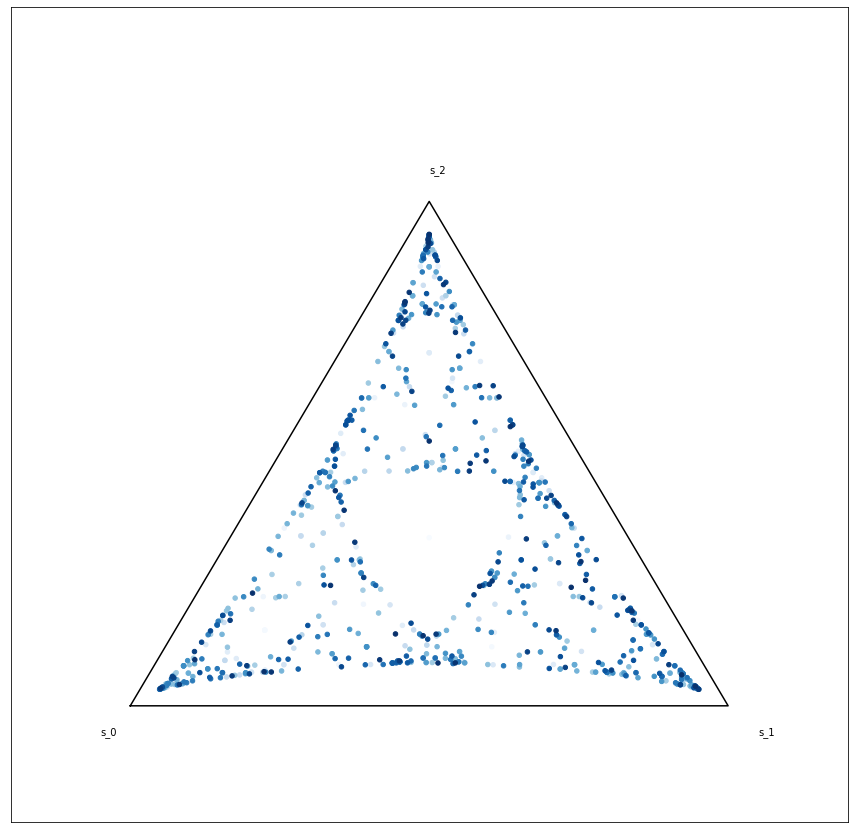

In [28]:
display_belief_set(belief_set)

## Simulation

In [29]:
def simulate(alpha_set, alpha_actions, sim_length=1000):
    start_state = random.choice(STATES) # unknown to agent
    state = start_state
    print(f'Agent starts in state {start_state}')
    cum_rewards = []

    # Belief of the agent
    belief = [1/STATE_COUNT] * STATE_COUNT
    # alpha_set and alpha_actions are known
    
    reward_tot = 0

    for i in range(sim_length):
        # 1. Find best action to take under current belief
        best_value = -math.inf
        best_action = None
        for i, alpha in enumerate(alpha_set):
            val = sum((belief[s] * alpha[s]) for s in STATES)
            if val > best_value:
                best_value = val
                best_action = alpha_actions[i]

        # Apply action, unknown to agent
        state = transition(state, best_action)

        # 2. Observe
        o = observe(state)

        # 3. Update belief
        belief = belief_update(belief, a, o)

        # Receive reward
        reward = 1 if random.random() < REWARD_PROBS[state] else 0 
        reward_tot += reward
        
        cum_rewards.append(reward_tot)
        
        
    # Finalize
    print(f'Agent received a total reward of {reward_tot}, meaning an avaerage reward of {reward_tot/sim_length}')
    return cum_rewards

In [30]:
alpha_set, alpha_actions, belief_set = pbvi_main([b_0], gamma_0, 10, 4, expand_ssea)

cum_rewards = simulate(alpha_set, alpha_actions, 10000)

Agent starts in state 1
Agent received a total reward of 4023, meaning an avaerage reward of 0.4023


In [31]:
def plot_rewards(cum_rewards):
    N = 0
    if isinstance(cum_rewards, dict):
        N = len(cum_rewards[list(cum_rewards.keys())[0]])
    else:
        N = len(cum_rewards)
        
    x = [i for i in range(N)]

    y_best = [x_i*max(REWARD_PROBS) for x_i in x]

    plt.figure(figsize=(10,5))
    plt.plot(x,y_best, color='red', linestyle='--', label='Max rewards')

    if isinstance(cum_rewards, dict):
        for label, y_true in cum_rewards.items():
            plt.plot(x,y_true, label=label)
    else:
        plt.plot(x,cum_rewards, label='Cummulative rewards')

    plt.legend(loc='upper left')
    plt.show()

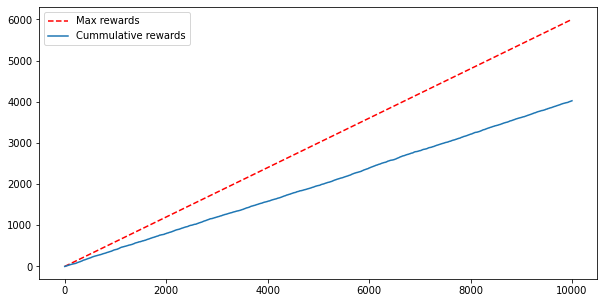

In [32]:
plot_rewards(cum_rewards)

## Tests

Agent starts in state 1
Agent received a total reward of 411, meaning an avaerage reward of 0.411
Agent starts in state 1
Agent received a total reward of 414, meaning an avaerage reward of 0.414
Agent starts in state 1
Agent received a total reward of 397, meaning an avaerage reward of 0.397


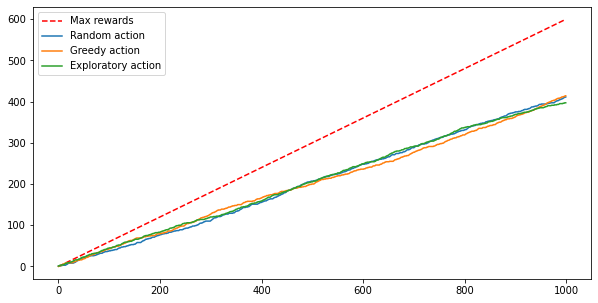

In [33]:
tests = {
    'Random action': expand_ssra,
    'Greedy action': expand_ssga,
    'Exploratory action': expand_ssea
}

results = {}

for name, expand_fnct in tests.items():
    alpha_set, alpha_actions, belief_set = pbvi_main([b_0], gamma_0, 10, 4, expand_fnct)
    cum_rewards = simulate(alpha_set, alpha_actions, 1000)
    
    results[name] = cum_rewards

plot_rewards(results)

## Plotting value function

In [34]:
def get_alpha_vect_z(xx, yy, alpha_vect):
    
    x0, y0, z0 = [0, 0, alpha_vect[0]]
    x1, y1, z1 = [0, 1, alpha_vect[1]]
    x2, y2, z2 = [1, 0, alpha_vect[2]]

    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

    u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

    point  = np.array([0, 0, alpha_vect[0]])
    normal = np.array(u_cross_v)

    d = -point.dot(normal)

    z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
    
    return z

In [56]:
alpha_set, alpha_actions, belief_set = pbvi_main([b_0], gamma_0, 10, 4, expand_ssea)

In [57]:
len(alpha_set)

196

In [58]:
alpha_set[:10]

[array([4.00679451, 4.00762768, 4.28086806]),
 array([4.18266888, 4.10153358, 3.97587037]),
 array([4.22473769, 4.0674201 , 3.99449033]),
 array([4.21722818, 4.07842415, 3.99929824]),
 array([3.99563584, 4.00780195, 4.28462868]),
 array([4.22376527, 4.06611798, 3.9987269 ]),
 array([3.99435151, 4.00629011, 4.28509965]),
 array([4.21733179, 4.07833607, 3.99937989]),
 array([4.22515551, 4.0664098 , 3.99276098]),
 array([3.96123232, 4.03273986, 4.25966021])]

In [59]:
def get_plane_gradient(alpha_vect):
        
    x0, y0, z0 = [0, 0, alpha_vect[0]]
    x1, y1, z1 = [0, 1, alpha_vect[1]]
    x2, y2, z2 = [1, 0, alpha_vect[2]]

    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

    u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]
    
    normal = np.array(u_cross_v)
    
    normal /= np.linalg.norm(normal)
    normal[2] = 0
    
    return np.linalg.norm(normal)
    
get_plane_gradient((alpha_set[0]))

0.26432684027273406

In [60]:
def plot_alpha_set(alpha_set, alpha_actions=None):
    x = np.linspace(0, 1, 1000)
    y = np.linspace(0, 1, 1000)

    xx, yy = np.meshgrid(x, y)

    max_z = np.zeros((xx.shape[0], yy.shape[0]))
    best_a = (np.zeros((xx.shape[0], yy.shape[0])))
    plane = (np.zeros((xx.shape[0], yy.shape[0])))
    gradients = (np.zeros((xx.shape[0], yy.shape[0])))

    for i, alpha in enumerate(alpha_set):

        z = get_alpha_vect_z(xx, yy, alpha)

        # Action array upodate
        new_a_mask = np.argmax(np.array([max_z, z]), axis=0)

        if alpha_actions is not None:
            best_a[new_a_mask == 1] = alpha_actions[i]
        
        plane[new_a_mask == 1] = random.randrange(100)
        
        alpha_gradient = get_plane_gradient(alpha)
        gradients[new_a_mask == 1] = alpha_gradient

        # Max z update
        max_z = np.max(np.array([max_z, z]), axis=0)
        
    for x_i, x_val in enumerate(x):
        for y_i, y_val in enumerate(y):
            if (x_val+y_val) > 1:
                max_z[x_i, y_i] = np.nan
                plane[x_i, y_i] = np.nan
                gradients[x_i, y_i] = np.nan
                best_a[x_i, y_i] = np.nan
                
    plt.figure(figsize=(25,20))

    plt.subplot(2, 2, 1)
    plt.title("Value function")
    plt.contourf(x, y, max_z, 100, cmap="viridis")
    plt.axis('scaled')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.title("Alpha planes")
    plt.contourf(x, y, plane, 100, cmap="viridis")
    plt.axis('scaled')
    
    
    plt.subplot(2, 2, 3)
    plt.title("Gradients of planes")
    plt.contourf(x, y, gradients, 100, cmap="Blues")
    plt.axis('scaled')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.title("Action policy")
    plt.contourf(x, y, best_a, 1, cmap="seismic")
    plt.axis('scaled')
    plt.colorbar()

    plt.show()

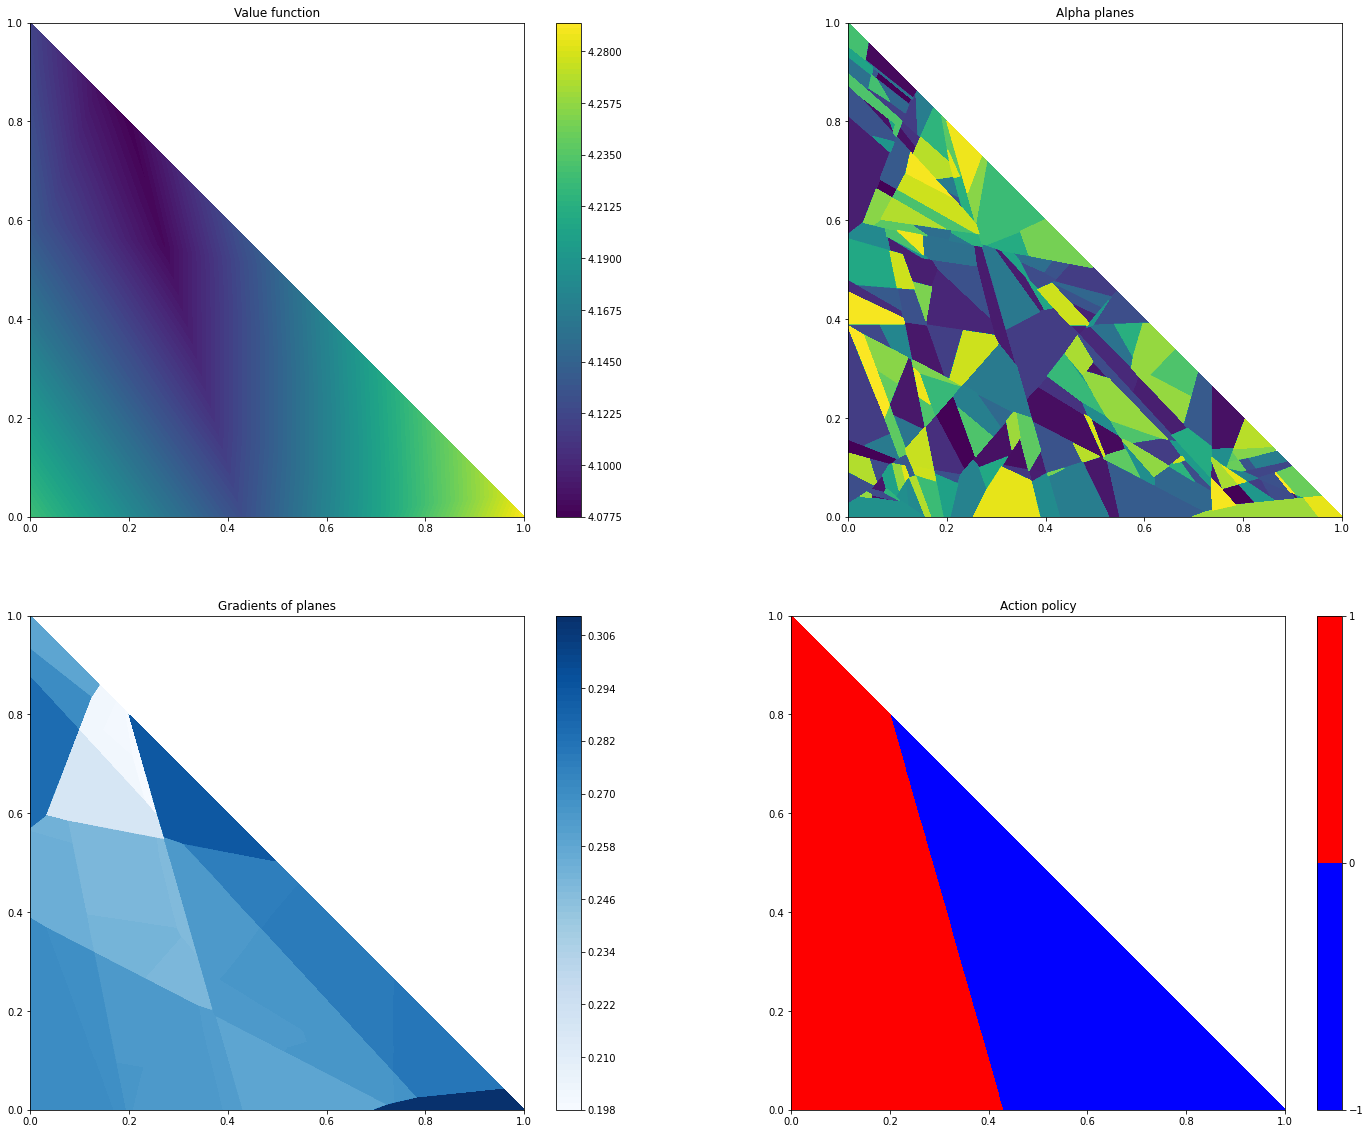

In [61]:
plot_alpha_set(alpha_set, alpha_actions)

# MDP version of the problem

## Value iteration

In [87]:
# Initiallize V as a |S| x |A| matrix of the reward expected when being in state s and taking action a
V = copy.deepcopy(reward_table)
# V = np.ones((STATE_COUNT, ACTION_COUNT)) * np.array(REWARD_PROBS).reshape((STATE_COUNT, 1)) # Starts with pure rewards
# V = np.zeros((STATE_COUNT, ACTION_COUNT)) # Start at zero
V_opt = V[:,0]
gamma = 0.99
theta = 0.001 # Stops if average change in V is lower than this
N = 10000 # Infinite loop failsafe
converged = False

while (not converged) and (N > 0):
    N -= 1
    
    old_V = copy.deepcopy(V)
    old_V_opt = copy.deepcopy(V_opt)

    for s in STATES:
        for a_i, a in enumerate(ACTIONS):
            V[s,a_i] = reward_table[s,a] + (gamma * sum(transition_table[s, a_i, s_p] * old_V[s,a_i] for s_p in STATES))

    V_opt = np.max(V, axis=1)
        
    avg_delta = np.average(np.abs(V_opt - old_V_opt))
    if avg_delta < theta:
        converged = True
        print(f'Converged with N remaining {N}')

Converged with N remaining 9412


In [88]:
V

array([[52.85706447, 52.85763426],
       [31.9138534 , 31.91404333],
       [24.93360607, 24.93284635]])

In [89]:
V_alphas = []
V_alpha_actions = []
for a_i, a in enumerate(ACTIONS):
    V_alphas.append(V[:, a_i])
    V_alpha_actions.append(a)

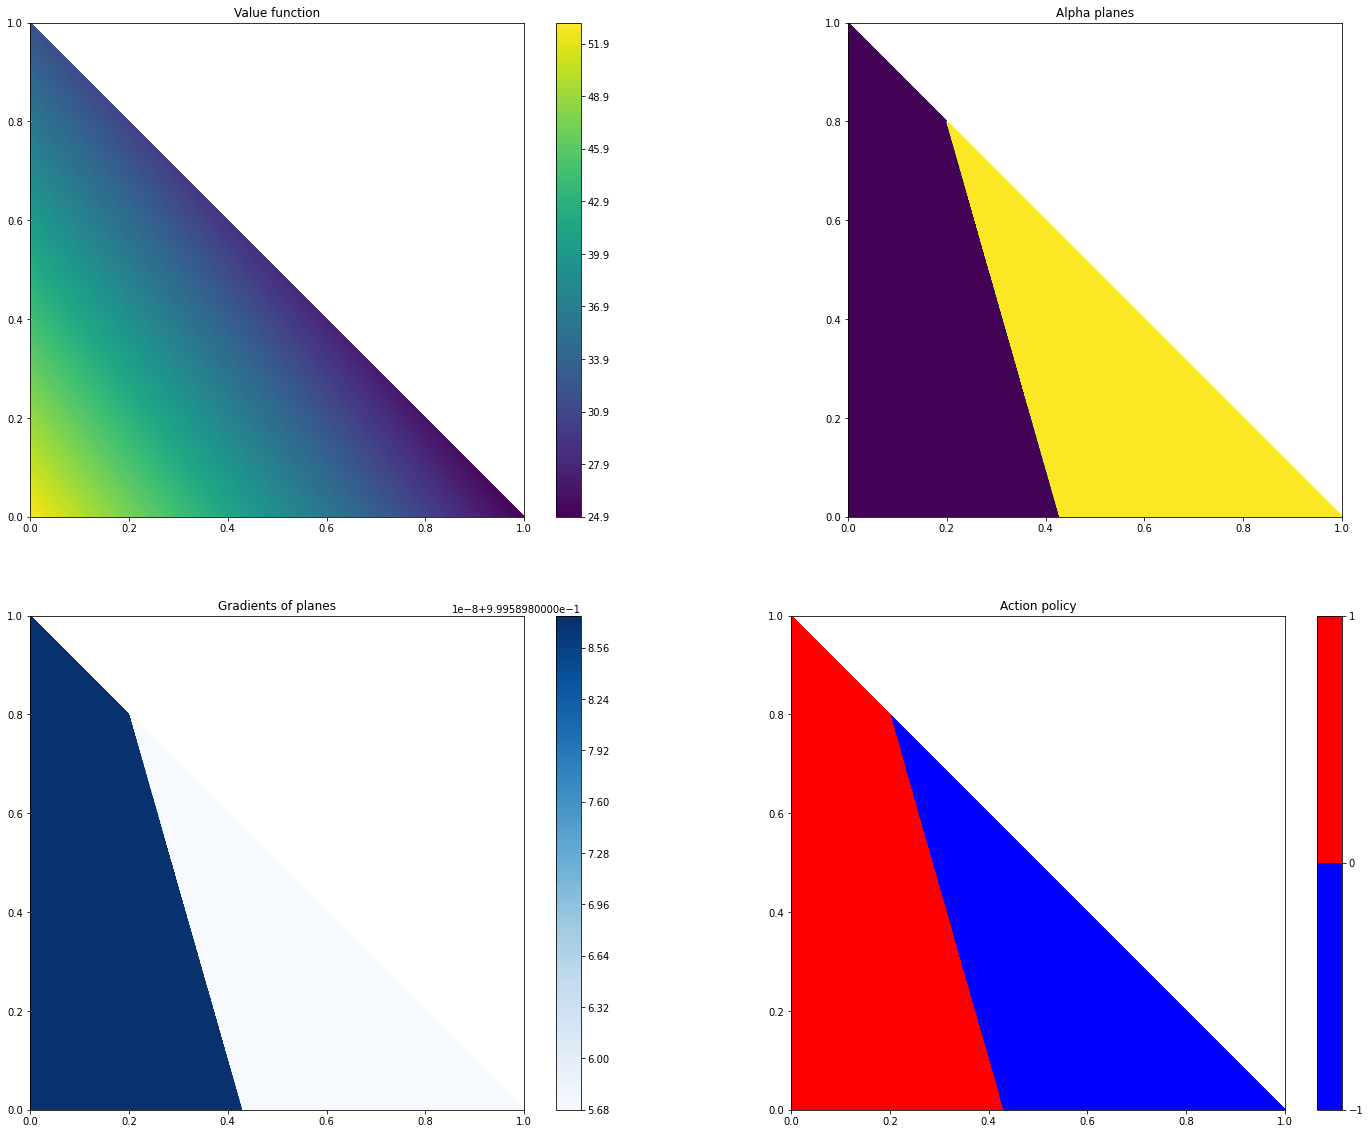

In [90]:
plot_alpha_set(V_alphas, V_alpha_actions)

## Policy iteration

In [52]:
# Policies to consider
policies = []
for i in range(ACTION_COUNT ** STATE_COUNT):
    string_actions = f'{i:03b}'
    policy_actions = [int(a) for a in string_actions]
    policies.append(policy_actions)
    
policies

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

In [53]:
gamma = 0.99
theta = 0.001

policy_V = {}

# Policy evaluation
for pol_index, pol in enumerate(policies):
    converged = False
    pol_V = np.array([reward_table[s, pol[s]] for s in STATES])
    
    N = 10000 # Infinite loop failsafe
    while (not converged) or (N < 0):
        N -= 1
        
        old_pol_V = copy.deepcopy(pol_V)
        
        for i, s in enumerate(STATES):
            pol_V[i] = reward_table[s,pol[i]] + (gamma * sum((transition_table[s, pol[i], s_p] * old_pol_V[s_p]) for s_p in STATES))
        
        avg_delta = np.average(np.abs(np.array(pol_V) - np.array(old_pol_V)))
        
        if avg_delta < theta:
            converged = True
            print(f'Pol {pol} finished eval with {N} iterations remaining: {pol_V}')
            
    policy_V[str(pol)] = pol_V

Pol [0, 0, 0] finished eval with 9412 iterations remaining: [36.58390378 36.46240827 36.65821188]
Pol [0, 0, 1] finished eval with 9438 iterations remaining: [28.21730855 28.17596183 28.17596183]
Pol [0, 1, 0] finished eval with 9399 iterations remaining: [41.72525813 41.72525813 41.84929829]
Pol [0, 1, 1] finished eval with 9436 iterations remaining: [28.62719742 28.62719742 28.5858507 ]
Pol [1, 0, 0] finished eval with 9404 iterations remaining: [39.80265086 39.63726397 39.80265086]
Pol [1, 0, 1] finished eval with 9408 iterations remaining: [38.16552156 38.00013467 38.00013467]
Pol [1, 1, 0] finished eval with 9396 iterations remaining: [43.07740281 42.95336264 43.07740281]
Pol [1, 1, 1] finished eval with 9412 iterations remaining: [36.6805333  36.49461811 36.52937253]


In [54]:
list(policy_V.values())

[array([36.58390378, 36.46240827, 36.65821188]),
 array([28.21730855, 28.17596183, 28.17596183]),
 array([41.72525813, 41.72525813, 41.84929829]),
 array([28.62719742, 28.62719742, 28.5858507 ]),
 array([39.80265086, 39.63726397, 39.80265086]),
 array([38.16552156, 38.00013467, 38.00013467]),
 array([43.07740281, 42.95336264, 43.07740281]),
 array([36.6805333 , 36.49461811, 36.52937253])]

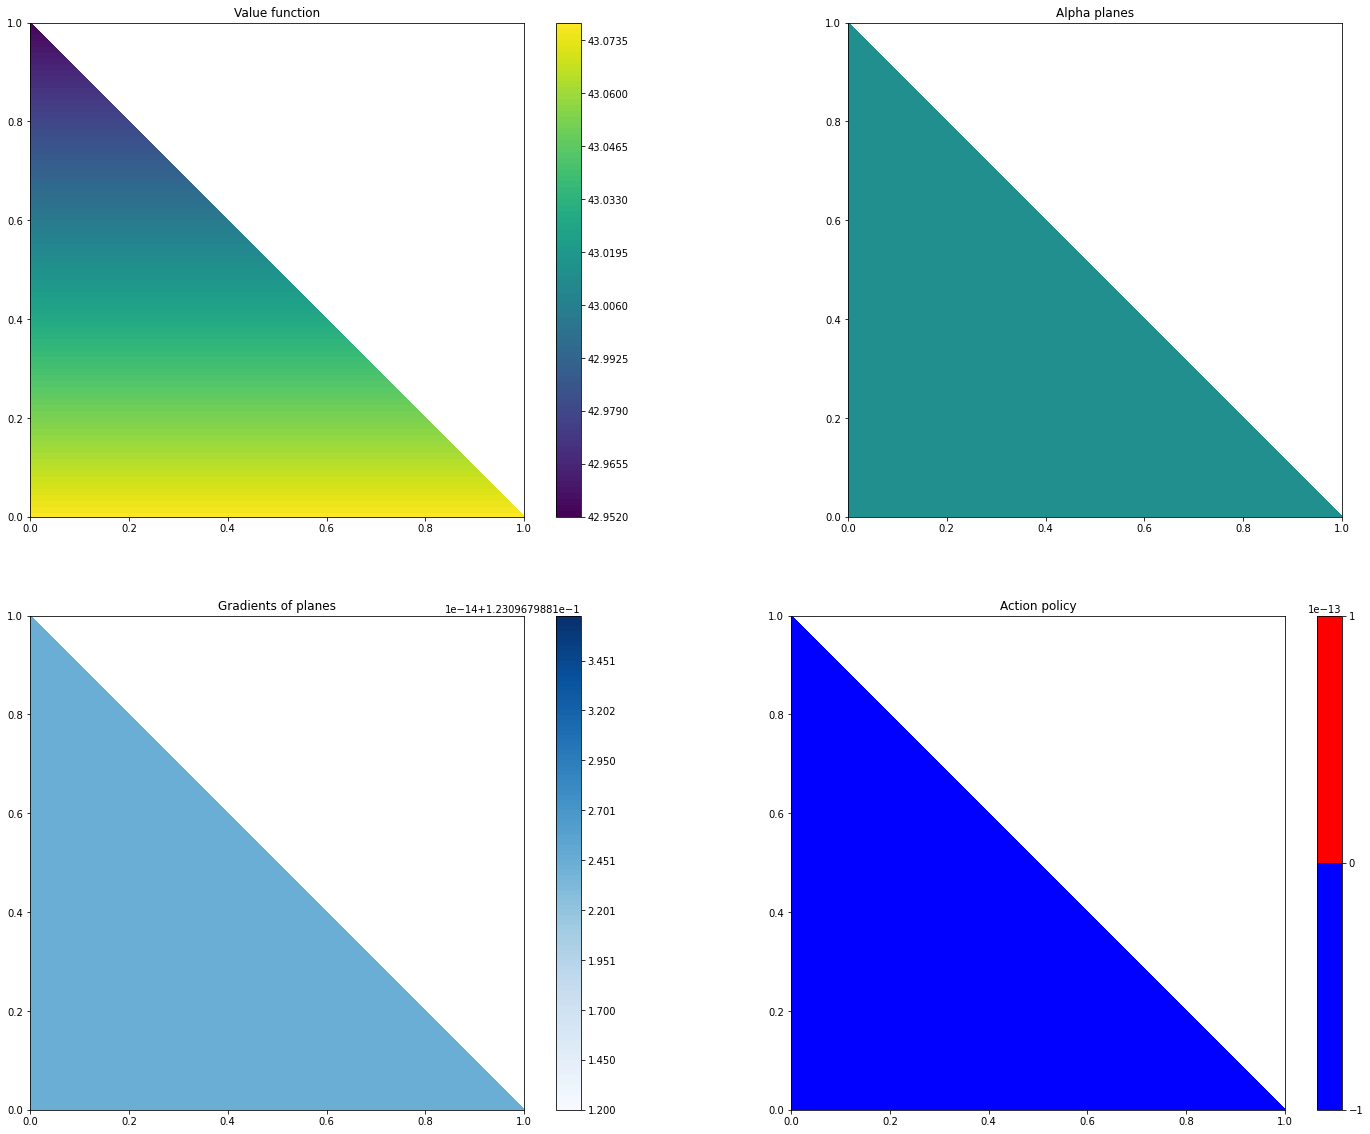

In [55]:
plot_alpha_set(list(policy_V.values()), None)

# Linear Programming pruning of alpha vectors